<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Author: Unknown_

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
# import package
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 
matplotlib.style.use('ggplot')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [2]:
# import dataset
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [3]:
# check dtypes
walmart.info()

# this dataset has 421,570 observations
# there is no missing value
# Date column is store in object type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [4]:
# change Date column from object to datetime type
walmart['Date'] = pd.to_datetime(walmart['Date'])

In [5]:
# check unique values in store column
print(np.array(pd.Series(walmart['Store'].unique()).sort_values()))
print('Unique Store:', len(np.array(pd.Series(walmart['Store'].unique()).sort_values())))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
Unique Store: 45


In [6]:
# check unique values in department column
print(np.array(pd.Series(walmart['Dept'].unique()).sort_values()))
print('Unique Department:', len(np.array(pd.Series(walmart['Dept'].unique()).sort_values())))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 58 59 60 65 67 71 72 74 77 78 79 80 81 82 83 85 87 90
 91 92 93 94 95 96 97 98 99]
Unique Department: 81


**Creating a datetime index**

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [7]:
# move Date column to index
walmart.set_index('Date', inplace=True)

In [8]:
# check index working correctly
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [9]:
# extract only Weekly sales from store 1  
walmart_store1 = walmart[walmart['Store']==1].groupby('Date').sum()

---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

In [10]:
# function for plot line chart
def plot_series(df, cols=None, title='Title', xlab=None, 
                ylab=None, steps=1):
    
    # Set figure size to be (18, 9)
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name
    for col in cols:
            
        # Generate a line plot of the column name
        # You only have to specify Y, since our
        # index will be a datetime index
        plt.plot(df[col])
        
    # Generate title and labels
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18);

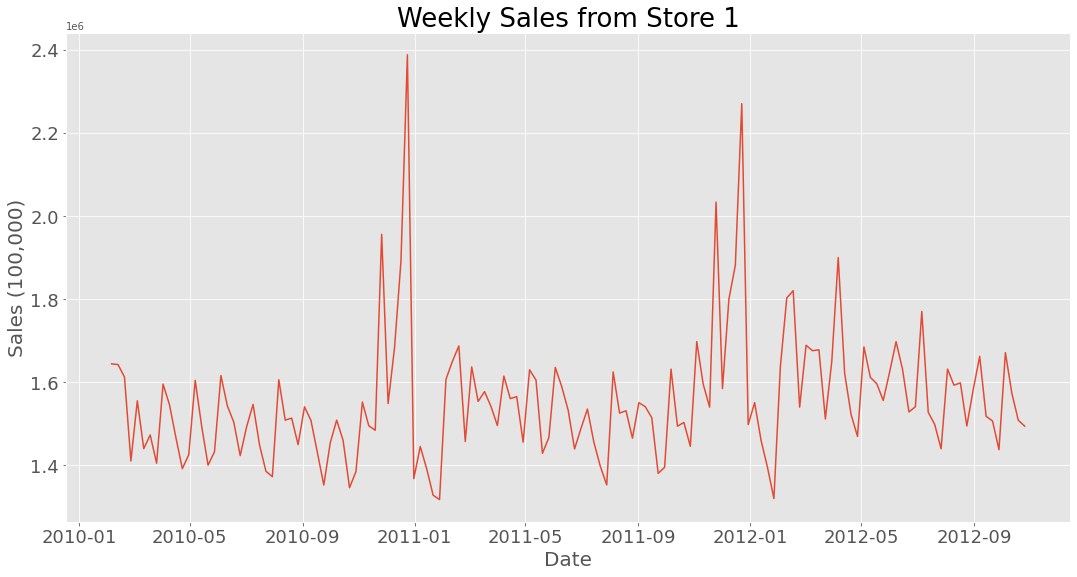

In [11]:
# plot weekly sales
plot_series(walmart_store1, ['Weekly_Sales'], title='Weekly Sales from Store 1', xlab='Date', ylab='Sales (100,000)', steps=10)

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

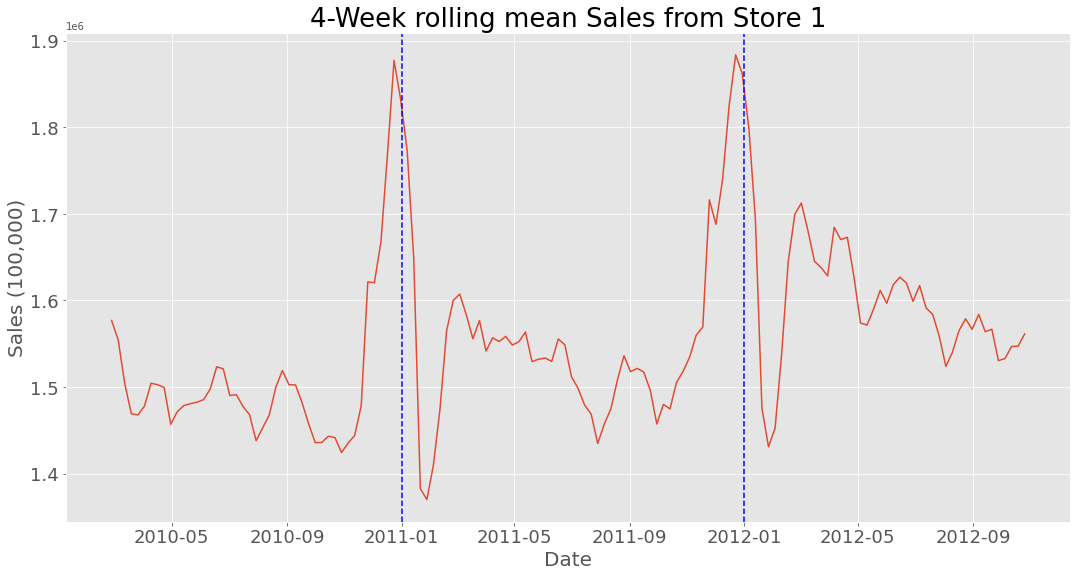

In [12]:
# plot 4 week rolling mean sales
plot_series(walmart_store1.rolling(4).mean().dropna()\
            , ['Weekly_Sales'], title='4-Week rolling mean Sales from Store 1', xlab='Date', ylab='Sales (100,000)', steps=20)
plt.axvline(dt.datetime(2011, 1, 1), color='b',  linestyle='--')
plt.axvline(dt.datetime(2012, 1, 1), color='b',  linestyle='--');

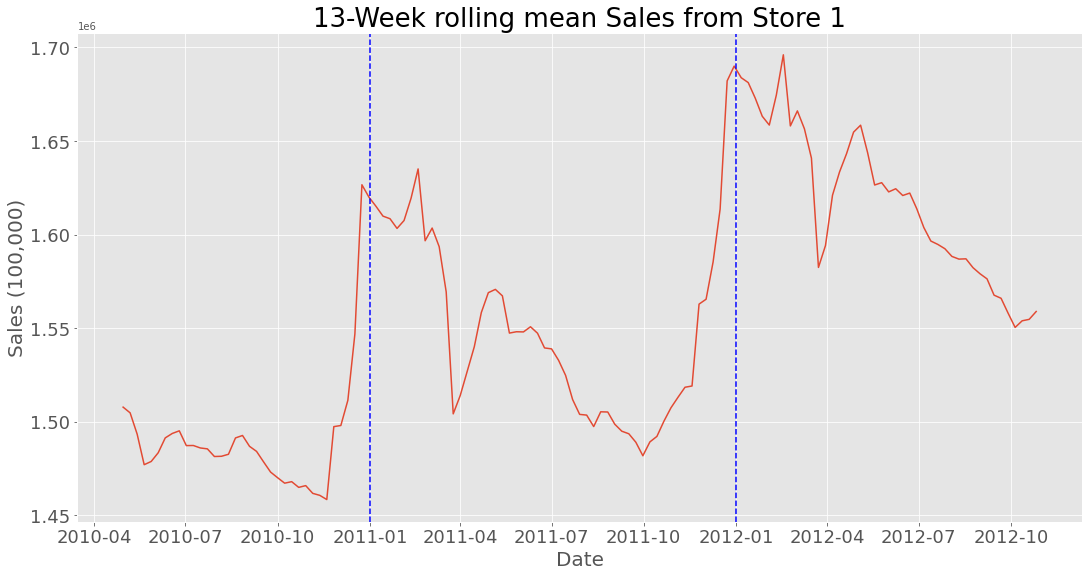

In [13]:
# plot 13 week rolling mean sales
plot_series(walmart_store1.rolling(13).mean().dropna()\
            , ['Weekly_Sales'], title='13-Week rolling mean Sales from Store 1', xlab='Date', ylab='Sales (100,000)', steps=20)
plt.axvline(dt.datetime(2011, 1, 1), color='b',  linestyle='--')
plt.axvline(dt.datetime(2012, 1, 1), color='b',  linestyle='--');

**Describe any trends that you notice**

From 13 week rolling mean sales from store 1 chart has show that it slightly increase after decreased.
And had Seasonality in all January.

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

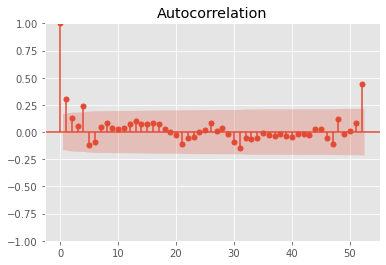

In [14]:
# plot ACF
plot_acf(walmart_store1['Weekly_Sales'], lags=52);

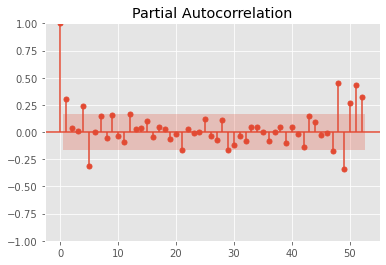

In [15]:
# plot PACF
plot_pacf(walmart_store1['Weekly_Sales'], lags=52);

From 2 charts Auto and Partial Autocorrelation have shown that the data have seasonality.

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [16]:
y_train, y_test = train_test_split(walmart_store1['Weekly_Sales'], test_size=0.1,
                                  shuffle=False)

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [17]:
print(f'P-value: {adfuller(y_train)[1]}')

P-value: 4.150561243767082e-05


Reject Null hypothesis.

---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [18]:
# Instantiate ARIMA set AR(1)
ar1 = ARIMA(y_train, order=(1, 0, 0))
model_ar1 = ar1.fit()

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data.

In [19]:
y_preds_ar1 = model_ar1.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Use the `mean_squared_error` function to identify the MSE on the testing data.

In [20]:
mean_squared_error(y_test, y_preds_ar1)

5188882502.605215

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

In [21]:
# create function plot arima prediction
# Instantiate best model
def plot_arima(preds, title=''):
    # Plot data.
    plt.figure(figsize=(12,8))

    # Plot training data
    plt.plot(y_train.index, pd.Series(y_train), color = 'blue')

    # Plot testing data
    plt.plot(y_test.index, pd.Series(y_test), color = 'orange', label='True')

    # Plot predicted test values
    plt.plot(y_test.index, preds, color = 'green', label='Predict')

    plt.title(label = title, 
              fontsize=16)
    plt.legend()
    plt.show();

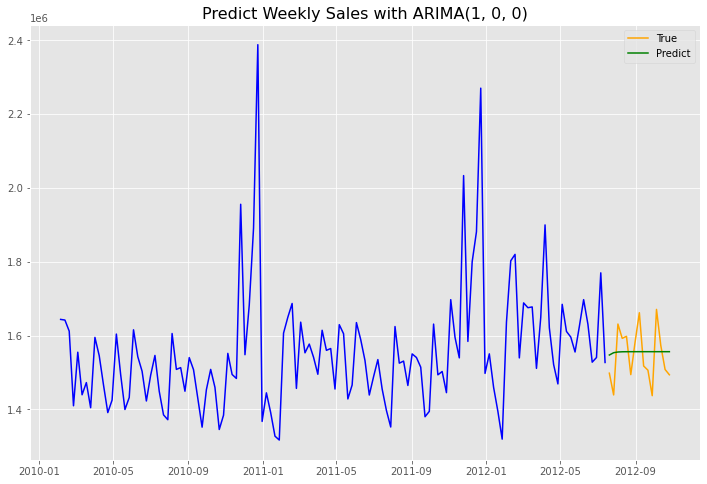

In [22]:
plot_arima(y_preds_ar1, 'Predict Weekly Sales with ARIMA(1, 0, 0)')

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

Model AR(1) perform poorly it only predict linear form.

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [23]:
ar2 = ARIMA(y_train, order=(2, 0, 2))
model_ar2 = ar2.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [24]:
y_preds_ar2 = model_ar2.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [25]:
mean_squared_error(y_test, y_preds_ar2)

4617986673.802609

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

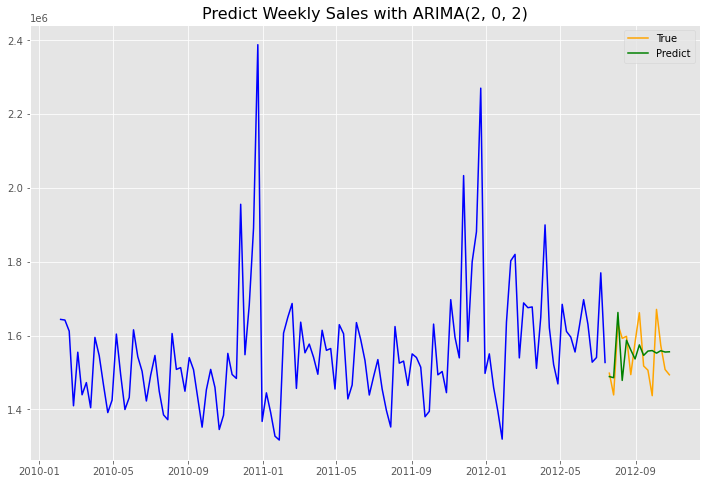

In [26]:
plot_arima(y_preds_ar2, 'Predict Weekly Sales with ARIMA(2, 0, 2)')

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

Model perform quite good at the first and then it lost pattern.

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [27]:
ar3 = ARIMA(y_train, order=(2, 1, 2))
model_ar3 = ar3.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [28]:
y_preds_ar3 = model_ar3.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [29]:
mean_squared_error(y_test, y_preds_ar3)

8383610307.852

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

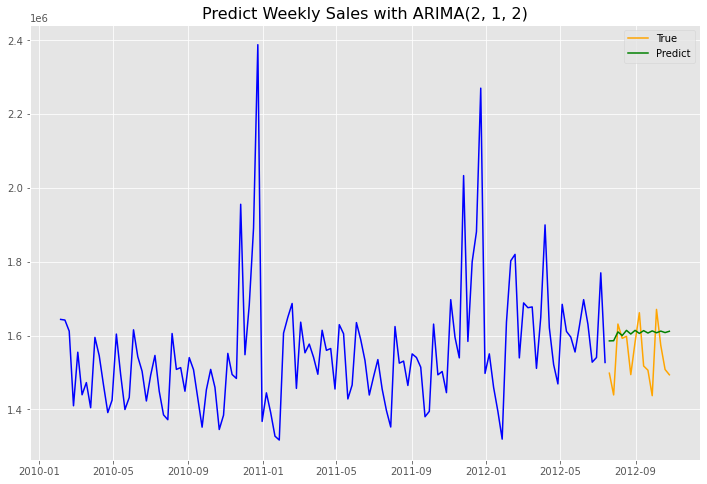

In [30]:
plot_arima(y_preds_ar3, 'Predict Weekly Sales with ARIMA(2, 1, 2)')

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

Model Perform poorly with rougly linear.

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [31]:
ar4 = ARIMA(y_train, order=(52, 0, 1))
model_ar4 = ar4.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [32]:
y_preds_ar4 = model_ar4.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [33]:
mean_squared_error(y_test, y_preds_ar4)

7894480470.926959

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

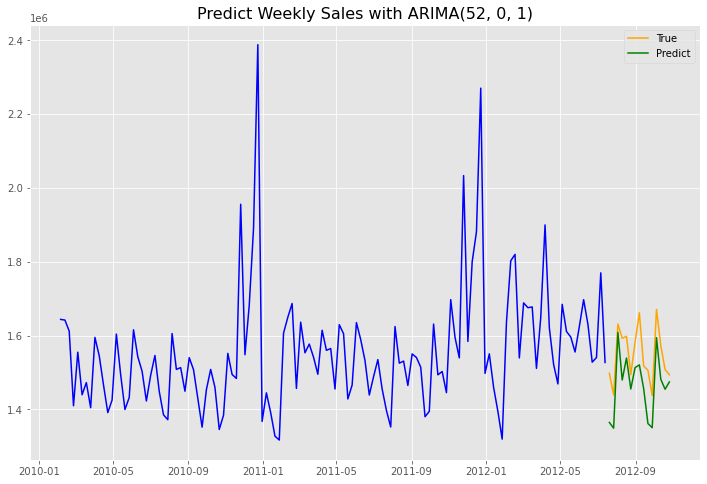

In [34]:
plot_arima(y_preds_ar4, 'Predict Weekly Sales with ARIMA(52, 0, 1)')

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

Model perform good enough but it quite predict lower than reality.

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

### SARIMA(2,0,2)

In [35]:
sari_1 = SARIMAX(y_train, order=(2, 0, 2), seasonal_order=(1,1,1,52))
model_sa1 = sari_1.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [36]:
y_preds_sa1 = model_sa1.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [37]:
mean_squared_error(y_test, y_preds_sa1)

1890785076.2316663

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

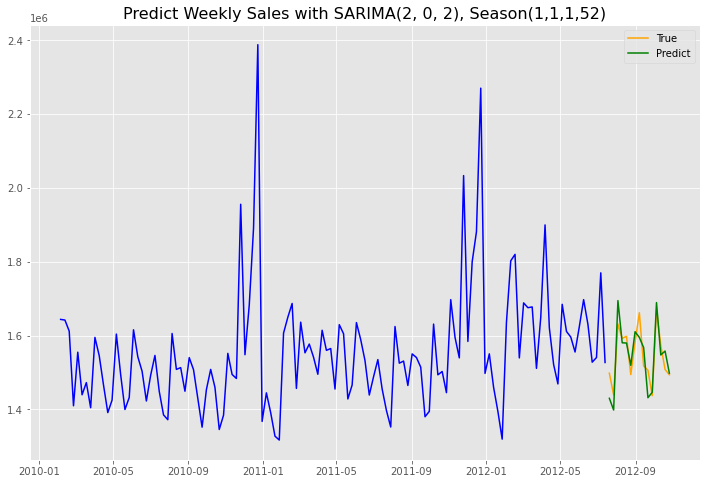

In [38]:
plot_arima(y_preds_sa1, 'Predict Weekly Sales with SARIMA(2, 0, 2), Season(1,1,1,52)')

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

With power of SARIMA model perform well almost fit the test value.